# 傅里叶变换

### 目标

在本节中，我们将学习
- 使用OpenCV查找图像的傅立叶变换
- 利用Numpy中可用的FFT函数
- 傅立叶变换的某些应用程序
- 我们将看到以下函数：**cv.dft**()，**cv.idft**()等

### 理论

傅立叶变换用于分析各种滤波器的频率特性。对于图像，使用**2D离散傅里叶变换**(DFT)查找频域。一种称为**快速傅立叶变换**(FFT)的快速算法用于DFT的计算。关于这些的详细信息可以在任何图像处理或信号处理教科书中找到。请参阅其他资源部分。

对于正弦信号$x(t) = A \sin(2 \pi ft)$，我们可以说$f$是信号的频率，如果采用其频域，则可以看到$f$的尖峰。如果对信号进行采样以形成离散信号，我们将获得相同的频域，但是在$[-π，π]$或$[0,2π]$范围内（对于N点DFT为$[0，N]$）是周期性的。您可以将图像视为在两个方向上采样的信号。因此，在X和Y方向都进行傅立叶变换，可以得到图像的频率表示。

更直观地说，对于正弦信号，如果幅度在短时间内变化如此之快，则可以说它是高频信号。如果变化缓慢，则为低频信号。您可以将相同的想法扩展到图像。图像中的振幅在哪里急剧变化？在边缘点或噪声。因此，可以说边缘和噪声是图像中的高频内容。如果幅度没有太大变化，则它是低频分量。（一些链接已添加到“其他资源”，其中通过示例直观地说明了频率变换）。

现在，我们将看到如何找到傅立叶变换。

### Numpy中的傅里叶变换

首先，我们将看到如何使用Numpy查找傅立叶变换。Numpy具有FFT软件包来执行此操作。**np.fft.fft2**()为我们提供了频率转换，它将是一个复杂的数组。它的第一个参数是输入图像，即灰度图像。第二个参数是可选的，它决定输出数组的大小。如果它大于输入图像的大小，则在计算FFT之前用零填充输入图像。如果小于输入图像，将裁切输入图像。如果未传递任何参数，则输出数组的大小将与输入的大小相同。

现在，一旦获得结果，零频率分量（DC分量）将位于左上角。如果要使其居中，则需要在两个方向上将结果都移动$\frac{N}{2}$。只需通过函数**np.fft.fftshift**()即可完成。（它更容易分析）。找到频率变换后，就可以找到幅度谱。

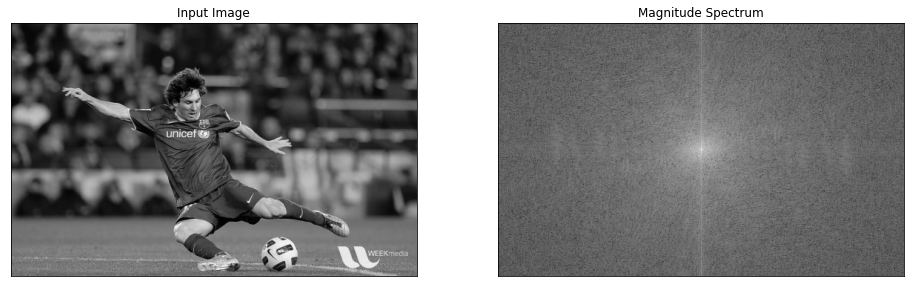

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

org = cv.imread('data/messi5.jpg')
img = cv.cvtColor(org,cv.COLOR_BGR2GRAY)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

看，您可以在中心看到更多白色区域，这表明低频内容更多。

因此，您发现了频率变换现在，您可以在频域中进行一些操作，例如高通滤波和重建图像，即找到逆DFT。为此，您只需用尺寸为60x60的矩形窗口遮罩即可消除低频。然后，使用**np.fft.ifftshift**()应用反向移位，以使DC分量再次出现在左上角。然后使用**np.ifft2**()函数找到逆FFT。同样，结果将是一个复数。您可以采用其绝对值。

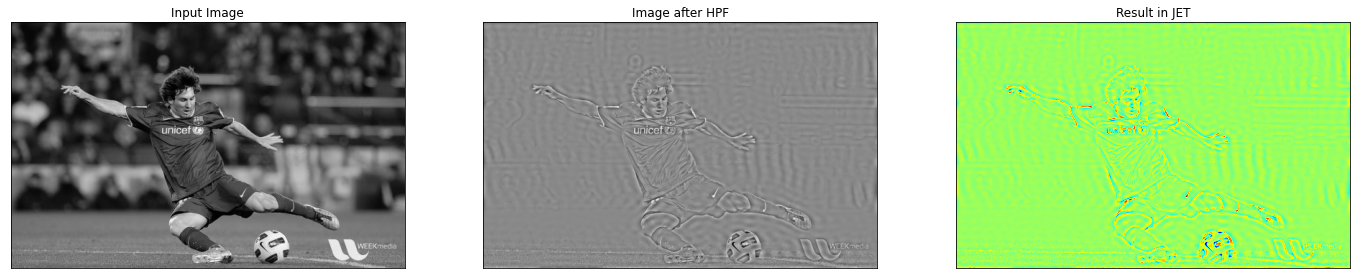

In [2]:
rows, cols = img.shape

crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
f_ishift = np.fft.ifftshift(fshift)

img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

plt.figure(figsize=(24,8))
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back, 'jet')
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

结果表明高通滤波是边缘检测操作。这就是我们在“图像渐变”一章中看到的。这也表明大多数图像数据都存在于频谱的低频区域。无论如何，我们已经看到了如何在Numpy中找到DFT，IDFT等。现在，让我们看看如何在OpenCV中进行操作。
如果您仔细观察结果，尤其是最后一张JET颜色的图像，您会看到一些伪像（我用红色箭头标记的一个实例）。它在那里显示出一些波纹状结构，称为**振铃效应**。这是由我们用于遮罩的矩形窗口引起的。此掩码转换为正弦形状，从而导致此问题。因此，矩形窗口不用于过滤。更好的选择是高斯窗口。

### OpenCV中的傅里叶变换

OpenCV为此提供了**cv.dft**()和**cv.idft**()函数。它返回与前一个相同的结果，但是有两个通道。第一个通道是结果的实部，第二个通道是结果的虚部。输入图像首先应转换为`np.float32`。我们来看看怎么做。

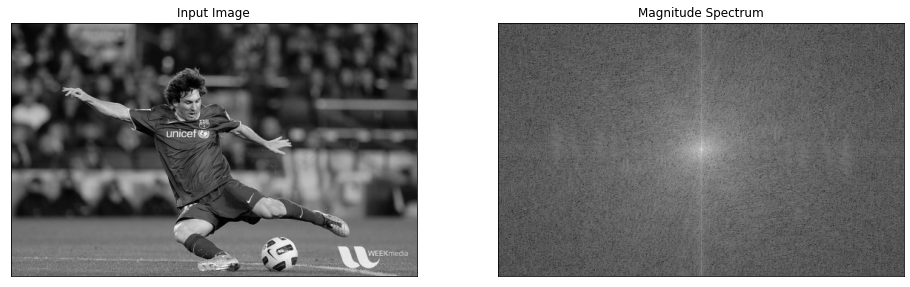

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/messi5.jpg',0)
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

> **注意**
  您还可以使用**cv.cartToPolar**()，它在单个镜头中同时返回幅值和相位

现在我们要做DFT的逆变换。在上一节中，我们创建了一个HPF，这次我们将看到如何删除图像中的高频内容，即我们将LPF应用到图像中。它实际上模糊了图像。为此，我们首先创建一个高值(1)在低频部分，即我们过滤低频内容，0在高频区。

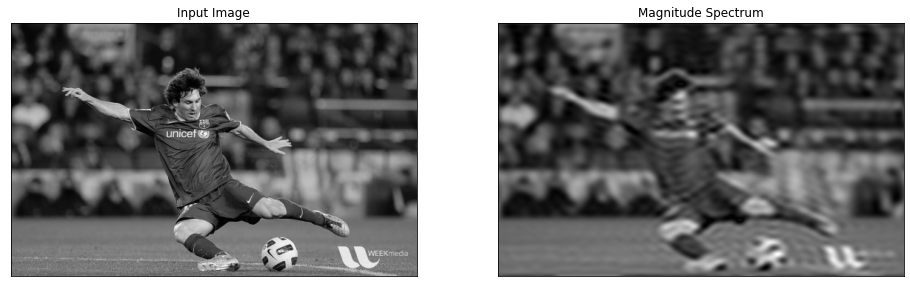

In [4]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)

# 首先创建一个掩码，中心正方形为1，其余全为零
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# 应用掩码和逆DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.figure(figsize=(16,8))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

> **注意**
通常，OpenCV函数**cv.dft**()和**cv.idft**()比Numpy函数更快。但是Numpy函数更容易使用。有关性能问题的更多细节，请参见下面的部分。

### DFT的性能优化

对于某些数组尺寸，DFT的计算性能较好。当数组大小为2的幂时，速度最快。对于大小为2、3和5的乘积的数组，也可以非常有效地进行处理。因此，如果您担心代码的性能，可以在找到DFT之前将数组的大小修改为任何最佳大小(通过填充零)。对于OpenCV，您必须手动填充零。但是对于Numpy，您指定FFT计算的新大小，它将自动为您填充零。

那么如何找到最优的大小呢?OpenCV为此提供了一个函数，**cv.getOptimalDFTSize**()。它同时适用于**cv.dft**()和**np.fft.fft2**()。让我们使用IPython魔术命令timeit来检查它们的性能。

In [5]:
img = cv.imread('data/messi5.jpg',0)
rows,cols = img.shape
print("%d %d" % (rows,cols))

342 548


In [6]:
nrows = cv.getOptimalDFTSize(rows)
ncols = cv.getOptimalDFTSize(cols)
print("%d %d" % (nrows,ncols))

360 576


参见，将大小`(342,548)`修改为`(360，576)`。现在让我们用零填充（对于OpenCV），并找到其DFT计算性能。您可以通过创建一个新的零数组并将数据复制到其中来完成此操作，或者使用**cv.copyMakeBorder**()。

In [7]:
nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = img

或者:

In [8]:
right = ncols - cols
bottom = nrows - rows
bordertype = cv.BORDER_CONSTANT
nimg = cv.copyMakeBorder(img,0,bottom,0,right,bordertype, value = 0)

现在，我们计算Numpy函数的DFT性能比较：

In [9]:
%timeit fft1 = np.fft.fft2(img)

25.2 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit fft2 = np.fft.fft2(img,[nrows,ncols])

10.7 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


它显示了4倍的加速。现在，我们将尝试使用OpenCV函数。

In [11]:
%timeit dft1= cv.dft(np.float32(img),flags=cv.DFT_COMPLEX_OUTPUT)

2.73 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit dft2= cv.dft(np.float32(nimg),flags=cv.DFT_COMPLEX_OUTPUT)

1.8 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


它还显示了4倍的加速。您还可以看到OpenCV函数比Numpy函数快3倍左右。也可以对逆FFT进行测试，这留给您练习。

### 为什么拉普拉斯算子是高通滤波器？

在一个论坛上也有人提出了类似的问题。问题是，为什么拉普拉斯变换是高通滤波器?为什么Sobel是HPF?等。第一个答案是关于傅里叶变换的。对于更大的FFT只需要拉普拉斯变换。分析下面的代码：

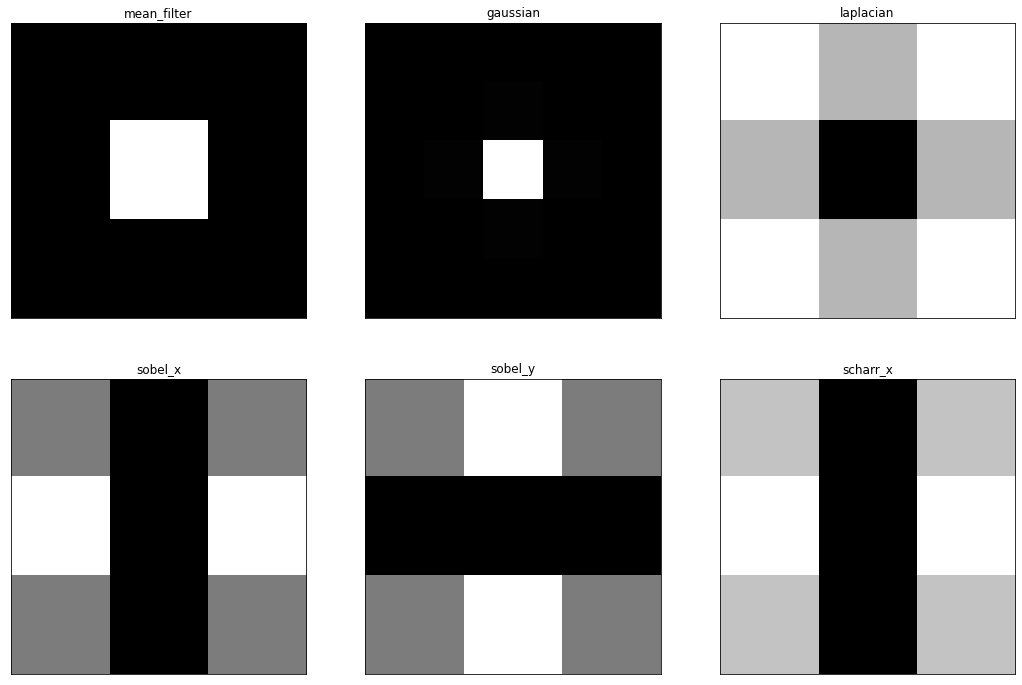

In [13]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 没有缩放参数的简单均值滤波器
mean_filter = np.ones((3,3))

# 创建高斯滤波器
x = cv.getGaussianKernel(5,10)
gaussian = x*x.T

# 不同的边缘检测滤波器
# x方向上的scharr
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])

# x方向上的sobel
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# y方向上的sobel
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])

# 拉普拉斯变换
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

plt.figure(figsize=(18,12))
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

从图像中，您可以看到每种内核阻止的频率区域以及它允许经过的区域。从这些信息中，我们可以说出为什么每个内核都是HPF或LPF

### 附加资源

1.傅里叶变换的直观解释：http://cns-alumni.bu.edu/~slehar/fourier/fourier.html by Steven Lehar
2. 傅里叶变换：http://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm at HIPR
3. 图像中的频率域指什么？http://dsp.stackexchange.com/q/1637/818

### 练习